In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
sw = pd.read_csv('starwars_script.csv')

In [5]:
sw

,character,dialogue,next_line
0,THREEPIO,did you hear that? they've shut down the main ...,we're
1,THREEPIO,we're doomed! [EOL],there'll
2,THREEPIO,there'll be no escape for the princess this ti...,what's
3,THREEPIO,what's that? [EOL],i
4,THREEPIO,i should have known better than to trust the l...,hurry
...,...,...,...
2459,LANDO,"wedge, i don't think we're going to make it. [...",you'll
2460,WEDGE,you'll make it. just follow me gold leader. [EOL],i
2461,LANDO,i promised to return his ship without a scratc...,lando...
2462,HAN,lando... [EOL],they


In [6]:
# initialize tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='[OOV]',lower=False)

In [7]:
tokenizer.fit_on_texts(sw.dialogue)

In [8]:
tokenizer.word_index

{'[OOV]': 1,
 'EOL': 2,
 'the': 3,
 'you': 4,
 'i': 5,
 'to': 6,
 'a': 7,
 'of': 8,
 'it': 9,
 'your': 10,
 'is': 11,
 'this': 12,
 'be': 13,
 'and': 14,
 'in': 15,
 'that': 16,
 'on': 17,
 'me': 18,
 'have': 19,
 'for': 20,
 'my': 21,
 "don't": 22,
 'are': 23,
 'no': 24,
 "i'm": 25,
 'not': 26,
 'will': 27,
 'all': 28,
 'what': 29,
 'we': 30,
 'he': 31,
 'here': 32,
 'with': 33,
 'luke': 34,
 'but': 35,
 'get': 36,
 'going': 37,
 'him': 38,
 'there': 39,
 'out': 40,
 "it's": 41,
 'do': 42,
 'right': 43,
 'oh': 44,
 'if': 45,
 'can': 46,
 'come': 47,
 'know': 48,
 'now': 49,
 'them': 50,
 'see': 51,
 'was': 52,
 'well': 53,
 "you're": 54,
 'as': 55,
 'sir': 56,
 'artoo': 57,
 'one': 58,
 'us': 59,
 'just': 60,
 'go': 61,
 "we're": 62,
 'they': 63,
 'got': 64,
 'good': 65,
 'up': 66,
 'about': 67,
 'back': 68,
 'take': 69,
 'at': 70,
 'so': 71,
 'like': 72,
 'has': 73,
 'chewie': 74,
 'must': 75,
 'only': 76,
 'yes': 77,
 'our': 78,
 'think': 79,
 'where': 80,
 "can't": 81,
 'ship': 82,

In [9]:
tokenizer.texts_to_sequences([sw.dialogue.iloc[0]])

[[109,
  4,
  292,
  16,
  474,
  309,
  96,
  3,
  250,
  525,
  148,
  13,
  442,
  20,
  121,
  12,
  11,
  1546,
  2]]

In [10]:
# Initialize the sequences list
input_sequences = []

# Loop over every line
for line in sw.dialogue:

	# Tokenize the current line
	token_list = tokenizer.texts_to_sequences([line])[0]

	# Loop over the line several times to generate the subphrases
	for i in range(1, len(token_list)):
		
		# Generate the subphrase
    # n_gram_sequence = token_list[:i+1]
		n_gram_sequence = token_list[:i]

		# Append the subphrase to the sequences list
		input_sequences.append(n_gram_sequence)

# Get the length of the longest line
max_sequence_len = max([len(x) for x in input_sequences])

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [12]:
total_words = len(tokenizer.word_index) + 1

# Create inputs and label by splitting the last token in the subphrases
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

# Convert the label into one-hot arrays
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [13]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Hyperparameters
embedding_dim = 100
lstm_units = 128
learning_rate = 0.01

# Build the model
model = Sequential([
          Embedding(total_words, embedding_dim, input_length=max_sequence_len-1),
          Bidirectional(LSTM(lstm_units)),
          # Dense(32,activation='relu'),
          Dense(total_words, activation='softmax')
])

In [14]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
    )

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 132, 100)          287100    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense (Dense)               (None, 2871)              737847    
                                                                 
Total params: 1,259,443
Trainable params: 1,259,443
Non-trainable params: 0
_________________________________________________________________


In [19]:
class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') is not None and logs.get('accuracy') > 0.90:
                print("\nReached 90% accuracy so cancelling training!") 
                
                # Stop training once the above condition is met
                self.model.stop_training = True

In [20]:
callbacks = myCallback()

In [61]:
epochs = 20

# Train the model
history = model.fit(xs, ys, epochs=epochs, callbacks=[callbacks])

Epoch 1/20
807/807 [==============================] - 295s 332ms/step - loss: 6.1054 - accuracy: 0.0742
Epoch 2/20
807/807 [==============================] - 268s 332ms/step - loss: 5.2496 - accuracy: 0.1237
Epoch 3/20
807/807 [==============================] - 268s 332ms/step - loss: 4.6915 - accuracy: 0.1500
Epoch 4/20
807/807 [==============================] - 265s 329ms/step - loss: 4.2408 - accuracy: 0.1807
Epoch 5/20
807/807 [==============================] - 255s 316ms/step - loss: 3.8583 - accuracy: 0.2157
Epoch 6/20
807/807 [==============================] - 251s 311ms/step - loss: 3.5464 - accuracy: 0.2517
Epoch 7/20
807/807 [==============================] - 258s 320ms/step - loss: 3.3094 - accuracy: 0.2813
Epoch 8/20
807/807 [==============================] - 264s 327ms/step - loss: 3.1055 - accuracy: 0.3146
Epoch 9/20
807/807 [==============================] - 263s 326ms/step - loss: 2.9566 - accuracy: 0.3350
Epoch 10/20
807/807 [==============================] - 265s 329m

In [64]:
 model.save('my_model.h5')

# Star Wars 4 Only

In [21]:
sw[sw.next_line == '[EOL]']

,character,dialogue,next_line
980,LUKE,he'll be all right. [EOL],[EOL]
1798,LUKE,ow! [EOL],[EOL]
2463,THREEPIO,they did it! [EOL],[EOL]


In [22]:
sw4 = sw.copy().loc[:980]
sw4

,character,dialogue,next_line
0,THREEPIO,did you hear that? they've shut down the main ...,we're
1,THREEPIO,we're doomed! [EOL],there'll
2,THREEPIO,there'll be no escape for the princess this ti...,what's
3,THREEPIO,what's that? [EOL],i
4,THREEPIO,i should have known better than to trust the l...,hurry
...,...,...,...
976,LEIA,"hey, i knew there was more to you than money. ...","oh,"
977,THREEPIO,"oh, my! artoo! can you hear me? say something!...",we'll
978,TECHNICIAN,we'll get to work on him right away. [EOL],you
979,THREEPIO,"you must repair him! sir, if any of my circuit...",he'll


In [23]:
# initialize tokenizer
tokenizersw4 = tf.keras.preprocessing.text.Tokenizer(oov_token='[OOV]',lower=False)
tokenizersw4.fit_on_texts(sw4.dialogue)
tokenizersw4.word_index

{'[OOV]': 1,
 'EOL': 2,
 'the': 3,
 'you': 4,
 'to': 5,
 'i': 6,
 'a': 7,
 'of': 8,
 'it': 9,
 'in': 10,
 'this': 11,
 'your': 12,
 'be': 13,
 'is': 14,
 'on': 15,
 'that': 16,
 'and': 17,
 'for': 18,
 'have': 19,
 'what': 20,
 'he': 21,
 'are': 22,
 "i'm": 23,
 'me': 24,
 "don't": 25,
 'all': 26,
 'here': 27,
 'going': 28,
 'we': 29,
 'my': 30,
 'not': 31,
 "it's": 32,
 'get': 33,
 'luke': 34,
 'with': 35,
 'there': 36,
 'if': 37,
 'but': 38,
 'can': 39,
 'out': 40,
 'him': 41,
 'no': 42,
 'right': 43,
 'do': 44,
 'one': 45,
 'will': 46,
 'come': 47,
 'about': 48,
 'sir': 49,
 'now': 50,
 "you're": 51,
 'was': 52,
 'them': 53,
 'see': 54,
 'know': 55,
 'up': 56,
 'got': 57,
 'us': 58,
 'just': 59,
 'think': 60,
 'well': 61,
 "we're": 62,
 'where': 63,
 'back': 64,
 'go': 65,
 'ship': 66,
 'like': 67,
 'at': 68,
 'they': 69,
 'been': 70,
 'only': 71,
 "i've": 72,
 'so': 73,
 'by': 74,
 'take': 75,
 "can't": 76,
 'as': 77,
 'more': 78,
 'time': 79,
 'look': 80,
 "he's": 81,
 'red': 82,


In [24]:
# Initialize the sequences list
input_sequences4 = []

# Loop over every line
for line in sw4.dialogue:

	# Tokenize the current line
	token_list = tokenizersw4.texts_to_sequences([line])[0]

	# Loop over the line several times to generate the subphrases
	for i in range(1, len(token_list)):
		
		# Generate the subphrase
    # n_gram_sequence = token_list[:i+1]
		n_gram_sequence = token_list[:i]

		# Append the subphrase to the sequences list
		input_sequences4.append(n_gram_sequence)

# Get the length of the longest line
max_sequence_len4 = max([len(x) for x in input_sequences4])

In [25]:
input_sequences4 = np.array(pad_sequences(input_sequences4, maxlen=max_sequence_len4, padding='pre'))

In [26]:
total_words4 = len(tokenizersw4.word_index) + 1

# Create inputs and label by splitting the last token in the subphrases
xs4, labels4 = input_sequences4[:,:-1],input_sequences4[:,-1]

# Convert the label into one-hot arrays
ys4 = tf.keras.utils.to_categorical(labels4, num_classes=total_words4)

In [64]:
# Hyperparameters
embedding_dim4 = 100
lstm_units4 = 128
learning_rate4 = 0.01

# Build the model
model4 = Sequential([
          Embedding(total_words4, embedding_dim4, input_length=max_sequence_len4-1),
          Bidirectional(LSTM(lstm_units4)),
          Dense(total_words4, activation='softmax')
])

model4.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate4), 
    metrics=['accuracy']
    )

model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 111, 100)          181400    
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 1814)              466198    
                                                                 
Total params: 882,094
Trainable params: 882,094
Non-trainable params: 0
_________________________________________________________________


In [65]:
epochs4 = 20

# Train the model
history4 = model4.fit(xs4, ys4, epochs=epochs4, callbacks=[callbacks])

Epoch 1/20
353/353 [==============================] - 92s 248ms/step - loss: 6.2934 - accuracy: 0.0504
Epoch 2/20
353/353 [==============================] - 87s 247ms/step - loss: 5.4312 - accuracy: 0.1041
Epoch 3/20
353/353 [==============================] - 87s 247ms/step - loss: 4.7025 - accuracy: 0.1482
Epoch 4/20
353/353 [==============================] - 87s 247ms/step - loss: 4.0292 - accuracy: 0.1992
Epoch 5/20
353/353 [==============================] - 87s 247ms/step - loss: 3.4192 - accuracy: 0.2650
Epoch 6/20
353/353 [==============================] - 87s 246ms/step - loss: 2.9090 - accuracy: 0.3453
Epoch 7/20
353/353 [==============================] - 88s 250ms/step - loss: 2.5192 - accuracy: 0.4155
Epoch 8/20
353/353 [==============================] - 87s 248ms/step - loss: 2.1893 - accuracy: 0.4842
Epoch 9/20
353/353 [==============================] - 88s 248ms/step - loss: 1.9476 - accuracy: 0.5376
Epoch 10/20
353/353 [==============================] - 87s 247ms/step - l

In [83]:
 model4.save('my_model4.h5')

# Overview

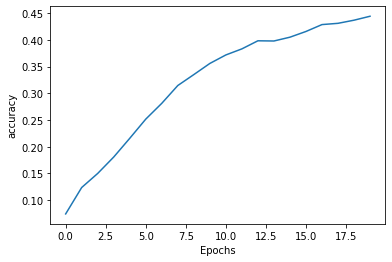

In [85]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')

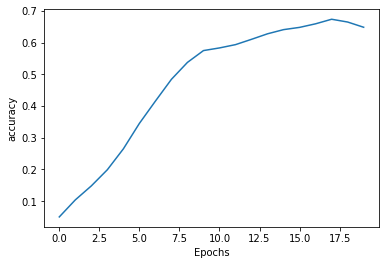

In [66]:
plot_graphs(history4, 'accuracy')

In [28]:
# Define seed text
seed_text = np.random.choice(list(tokenizer.word_index))

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
	token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	
	# Feed to the model and get the probabilities for each index
	probabilities = model.predict(token_list)

	# Get the index with the highest probability
	predicted = np.argmax(probabilities, axis=-1)[0]

	# Ignore if index is 0 because that is just the padding.
	if predicted != 0:
		
		# Look up the word associated with the index. 
		output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
		seed_text += " " + output_word

# Print the result	
print(seed_text)

according to the log the crew abandoned there in how we don't tell you back but he says you didn't want to her come around they must have to wait until morning systems out attack kind of it stay with him as a token of my goodwill i present to return the sand people return we betrayed for the shuttle disguised as fast as anchorhead and the wookiee to make an old man got to save you at the bunker right self of the present i've just received word you beast can be a strong defense need you stay here with


In [29]:
# Define seed text
seed_text = np.random.choice(list(tokenizersw4.word_index))

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
  token_list = tokenizersw4.texts_to_sequences([seed_text])[0]

	# Pad the sequence
  token_list = pad_sequences([token_list], maxlen=max_sequence_len4-1, padding='pre')
	
	# Feed to the model and get the probabilities for each index
  probabilities = model4.predict(token_list)

	# Get the index with the highest probability
  predicted = np.argmax(probabilities, axis=-1)[0]

	# Ignore if index is 0 because that is just the padding.
  if predicted != 0:
		
		# Look up the word associated with the index. 
    output_word = tokenizersw4.index_word[predicted]

		# Combine with the seed text
    seed_text += " " + output_word

# Print the result	
print(seed_text)

crush drafted drafted drafted effort effort pointless hold too hold effort effort weakness effort effort effort territories territories territories territories territories territories territories hate territories territories parsecs weakness weakness clear weakness clear resistance resistance resistance resistance drafted drafted clear resistance resistance clear resistance resistance resistance clear resistance resistance drafted drafted hold hold hold hold waste waste weakness effort effort effort weakness effort effort weakness effort effort weakness effort weakness effort effort weakness effort weakness effort effort weakness effort weakness effort effort weakness effort weakness effort effort weakness effort weakness effort effort weakness effort weakness effort weakness effort effort weakness effort weakness


# Model Generate Next Line

In [30]:
# Hyperparameters
embedding_dim = 64
filters = 128
kernel_size = 5
dense_dim = 64

model_line = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words, embedding_dim),
    tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(total_words, activation='softmax')
])

model_line.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
    metrics=['accuracy']
    )

# Print the model summary
model_line.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          183744    
                                                                 
 conv1d (Conv1D)             (None, None, 128)         41088     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 2871)              186615    
                                                                 
Total params: 419,703
Trainable params: 419,703
Non-trainable params: 0
________________________________________________

In [31]:
sw

,character,dialogue,next_line
0,THREEPIO,did you hear that? they've shut down the main ...,we're
1,THREEPIO,we're doomed! [EOL],there'll
2,THREEPIO,there'll be no escape for the princess this ti...,what's
3,THREEPIO,what's that? [EOL],i
4,THREEPIO,i should have known better than to trust the l...,hurry
...,...,...,...
2459,LANDO,"wedge, i don't think we're going to make it. [...",you'll
2460,WEDGE,you'll make it. just follow me gold leader. [EOL],i
2461,LANDO,i promised to return his ship without a scratc...,lando...
2462,HAN,lando... [EOL],they


In [32]:
xs_line = tokenizer.texts_to_sequences(sw.dialogue)
xs_line = np.array(pad_sequences(xs_line, maxlen=max_sequence_len, padding='pre'))

In [33]:
ys_line = tokenizer.texts_to_sequences(sw.next_line)

In [34]:
for i in range(len(ys_line)):
  if len(ys_line[i]) == 0:
    ys_line[i] = [tokenizer.word_index['[OOV]']]

In [35]:
ys_line = np.array([i[0] for i in ys_line])

In [36]:
ys_line = tf.keras.utils.to_categorical(ys_line, num_classes=total_words)

In [38]:
history_line = model_line.fit(xs_line, ys_line, epochs=100, callbacks=[callbacks])

Epoch 1/100
77/77 [==============================] - 4s 57ms/step - loss: 5.4672 - accuracy: 0.0795
Epoch 2/100
77/77 [==============================] - 3s 35ms/step - loss: 5.0807 - accuracy: 0.0812
Epoch 3/100
77/77 [==============================] - 3s 36ms/step - loss: 4.8310 - accuracy: 0.0787
Epoch 4/100
77/77 [==============================] - 3s 36ms/step - loss: 4.5897 - accuracy: 0.0804
Epoch 5/100
77/77 [==============================] - 3s 36ms/step - loss: 4.3144 - accuracy: 0.1067
Epoch 6/100
77/77 [==============================] - 3s 36ms/step - loss: 3.8973 - accuracy: 0.1818
Epoch 7/100
77/77 [==============================] - 3s 36ms/step - loss: 3.6196 - accuracy: 0.2338
Epoch 8/100
77/77 [==============================] - 3s 35ms/step - loss: 3.2650 - accuracy: 0.3011
Epoch 9/100
77/77 [==============================] - 3s 35ms/step - loss: 2.8862 - accuracy: 0.3726
Epoch 10/100
77/77 [==============================] - 3s 36ms/step - loss: 2.6383 - accuracy: 0.4099

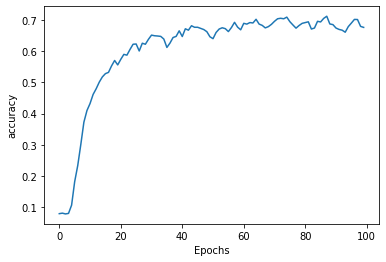

In [41]:
plot_graphs(history_line,'accuracy')

In [42]:
xs_line4 = tokenizersw4.texts_to_sequences(sw4.dialogue)
xs_line4 = np.array(pad_sequences(xs_line4, maxlen=max_sequence_len4, padding='pre'))

ys_line4 = tokenizersw4.texts_to_sequences(sw4.next_line)
for i in range(len(ys_line4)):
  if len(ys_line4[i]) == 0:
    ys_line4[i] = [tokenizersw4.word_index['[OOV]']]

ys_line4 = np.array([i[0] for i in ys_line4])
ys_line4 = tf.keras.utils.to_categorical(ys_line4, num_classes=total_words4)

In [43]:
# Hyperparameters
embedding_dim = 64
filters = 128
kernel_size = 5
dense_dim = 64

model_line4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words4, embedding_dim),
    tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(total_words4, activation='softmax')
])

model_line4.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
    metrics=['accuracy']
    )

# Print the model summary
model_line4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          116096    
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         41088     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1814)              117910    
                                                                 
Total params: 283,350
Trainable params: 283,350
Non-trainable params: 0
________________________________________________

In [44]:
history_line4 = model_line4.fit(xs_line4, ys_line4, epochs=100, callbacks=[callbacks])

Epoch 1/100
31/31 [==============================] - 4s 58ms/step - loss: 6.1328 - accuracy: 0.0632
Epoch 2/100
31/31 [==============================] - 2s 61ms/step - loss: 5.0093 - accuracy: 0.0846
Epoch 3/100
31/31 [==============================] - 2s 64ms/step - loss: 4.6820 - accuracy: 0.0877
Epoch 4/100
31/31 [==============================] - 2s 61ms/step - loss: 4.2973 - accuracy: 0.1101
Epoch 5/100
31/31 [==============================] - 1s 41ms/step - loss: 3.6503 - accuracy: 0.2059
Epoch 6/100
31/31 [==============================] - 1s 30ms/step - loss: 2.8548 - accuracy: 0.3547
Epoch 7/100
31/31 [==============================] - 1s 29ms/step - loss: 2.1955 - accuracy: 0.4852
Epoch 8/100
31/31 [==============================] - 1s 30ms/step - loss: 1.7338 - accuracy: 0.5800
Epoch 9/100
31/31 [==============================] - 1s 29ms/step - loss: 1.3758 - accuracy: 0.6493
Epoch 10/100
31/31 [==============================] - 1s 30ms/step - loss: 1.1433 - accuracy: 0.7074

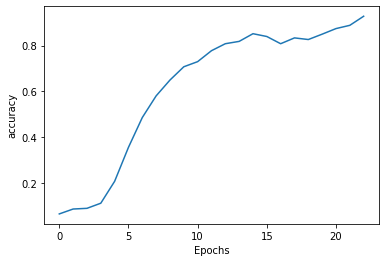

In [45]:
plot_graphs(history_line4,'accuracy')

In [46]:
def create_line(model,tokenizerr,max_sequence_len,seed_text_=None,next_words=100):
    # Define seed text
  seed_text = seed_text_ if seed_text_ != None else np.random.choice(list(tokenizerr.word_index)[1:])

  # Define total words to predict
  next_words = next_words

  # Loop until desired length is reached
  for _ in range(next_words):

    # Convert the seed text to a token sequence
    token_list = tokenizerr.texts_to_sequences([seed_text])[0]

    # Pad the sequence
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    
    # Feed to the model and get the probabilities for each index
    probabilities = model.predict(token_list)

    # Get the index with the highest probability
    predicted = np.argmax(probabilities, axis=-1)[0]

    # Ignore if index is 0 because that is just the padding.
    if predicted != 0:
      
      # Look up the word associated with the index. 
      output_word = tokenizerr.index_word[predicted]

      # Combine with the seed text
      seed_text += " " + output_word

      if output_word == 'EOL':
        return seed_text

  # Print the result	
  return seed_text

In [58]:
create_line(model,tokenizer,max_sequence_len,next_words=20)

"surviving your rear work with me obi wan kenobi you're my only hope help me obi wan kenobi you're my only"

In [48]:
def create_seed_text(model,tokenizerr,text,max_sequence_len):
  token_list = tokenizerr.texts_to_sequences([text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  probabilities = model.predict(token_list)
  predicted = np.argmax(probabilities, axis=-1)[0]
  output_word = tokenizerr.index_word[predicted]
  while predicted == 0:
    output_word = tokenizerr.index_word[predicted]
  return output_word

In [59]:
random_line = create_line(model,tokenizer,max_sequence_len,next_words=20)

In [50]:
create_seed_text(model_line,tokenizer,random_line,max_sequence_len)

'obi'

In [60]:
random_line

"correct we'll destroy you to talk to the dagobah system the way of the force and it is relatively unprotected but"

In [68]:
random_line4 = create_line(model4,tokenizersw4,max_sequence_len4,next_words=100)
random_line4

"cooked she's on a lot of simple tricks and nonsense the care of the last time i by the old man wants us to alderaan one enough droids until morning on a chain reaction the shaft is ray shielded so they must be able to pull us clear down up it immediately us a couple of shooting stars that'll never around those giant starships you're beginning to sound like my father in the bridge side of mos eisley but they are you going to be nothing more be malfunctioning within a day you nearsighted scrap pile a things a little extra"

In [53]:
create_seed_text(model_line4,tokenizersw4,random_line4,max_sequence_len4)

'i'

In [54]:
def create_script(model,model_line,tokenizerr,max_sequence_len,max_word,n_lines):
  lines = []
  seed_text = np.random.choice(list(tokenizerr.word_index)[1:])
  for _ in range(n_lines):
    line = create_line(model,tokenizerr,max_sequence_len,next_words=max_word)
    # print("kocak",line)
    seed_text = create_seed_text(model_line,tokenizerr,line,max_sequence_len)
    lines.append(line)
  return lines

In [69]:
script = create_script(model4,model_line4,tokenizersw4,max_sequence_len4,100,10)

In [70]:
script

["thousand we don't serve their kind here better of any use the comlink oh the empire to draft me for a thousand generations the planet is operational we are meant on the exhaust port are you in the galaxy will be the only one we will soon be back and in greater numbers for the rest of the season you should have been now and my father die i found those plans and bring the end of the empire to draft me into service the rebellion is spreading and i can't shake him but i can't shake him i can't shake",
 "shows well if we can go on him right away has seen luke take that r2 unit we bought might soon be with this planet to alderaan one day whammo you're going to make us go off in escape for the ease of yourself you'll always be the boy in the force as i know what is that he has in range in range for a good pilot like you to be my guest at a ceremony that will make this battle station is operational no star system will dare oppose the emperor now the data tapes of a person of",
 "nice come on

In [75]:
for dialogue in script:
  k = 0
  for word in dialogue.split():
    if k%15 == 0:
      print()
    print(word,end=' ')
    k+=1
  print()


thousand we don't serve their kind here better of any use the comlink oh the 
empire to draft me for a thousand generations the planet is operational we are meant 
on the exhaust port are you in the galaxy will be the only one we 
will soon be back and in greater numbers for the rest of the season you 
should have been now and my father die i found those plans and bring the 
end of the empire to draft me into service the rebellion is spreading and i 
can't shake him but i can't shake him i can't shake 

shows well if we can go on him right away has seen luke take that 
r2 unit we bought might soon be with this planet to alderaan one day whammo 
you're going to make us go off in escape for the ease of yourself you'll 
always be the boy in the force as i know what is that he has 
in range in range for a good pilot like you to be my guest at 
a ceremony that will make this battle station is operational no star system will dare 
oppose the emperor now the data tapes of a person of 

nice 

In [57]:
model_line.save('model_line.h5')
model_line4.save('model_line4.h5')